In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
from scipy.cluster.vq import vq, kmeans, whiten

#to make my plotting style
plt.rcParams["axes.facecolor"] = (1,1,.99) 
plt.rcParams["font.size"] = 15 
plt.rcParams["figure.figsize"] = (12,6) 
plt.rcParams["ytick.labelsize"] = 13 
plt.rcParams["xtick.labelsize"] = 13 
plt.rcParams["lines.linewidth"] = 2 
plt.rcParams["axes.titlesize"] = 17 

### Globals

In [109]:
NUM_PARTY_REPS = 1

### Geometry and function for generating random districts

In [110]:
# functions to get points on sides given x
def y_bottom(x):
    return 0
def y_left(x):
    return x * np.sqrt(3)
def y_right(x):
    return np.sqrt(3) * (1000 - x)

# check bounds
def in_bounds(point):
    x, y = point[0], point[1]
    condition1 = y >= y_bottom(x)
    condition2 = y <= y_left(x)
    condition3 = y <= y_right(x)
    return condition1 and condition2 and condition3

def generate_random_centroids(num_districts):
    centroids = np.zeros((num_districts,2))
    for i in range(num_districts):
        while True:
            x = np.random.random() * 1000
            y = np.random.random() * 1000
            proposal = np.array([x,y])
            if in_bounds(proposal):
                centroids[i] = proposal
                break
                
    return centroids

### Map information extraction functions

In [111]:
num_population = 333333
num_parties = 2 # default
Population_coords = []
Preferences = []

def extractMapInfo(textfile):
    with open(textfile) as f:
        first_line = f.readline().split(" ")
        # get num_population
        file_num_population = int(first_line[0])

        # get num_parties
        num_parties = int(first_line[1])
        
        for i in range(file_num_population):
            person = f.readline().rstrip('\n').split(" ")
            Population_coords.append([float(x)  for x in person[:2]])
            Preferences.append(person[2:(2 + num_parties)])
    
path = "/Users/rcalinsky/Dropbox/Columbia/4444/pps-election/10_9_results_submission/utah_2_better_map"

extractMapInfo(path)





### Extract Populations by preference to be used for more sophisticated k-means centroids

In [112]:
Pop_1_coords = []
Pop_2_coords = []
Pop_3_coords = []

def extractSubPopulationCoords():
    party_pref = 1 # default
    
    for i in range(len(Population_coords)):
        for j in range(num_parties):
            # if this preference is the highest
            if Preferences[i][j] == max(Preferences[i]):
                if j == 0:
                    Pop_1_coords.append(Population_coords[i])
                if j == 1:
                    Pop_2_coords.append(Population_coords[i])
                if j == 2:
                    Pop_3_coords.append(Population_coords[i])

extractSubPopulationCoords()             
                    
#print(Pop_1_coords)
#print(len(Pop_1_coords))

#print(Pop_2_coords)
#print(len(Pop_2_coords))

#print(Pop_3_coords)
#print(len(Pop_3_coords))

#print(len(Pop_1_coords) + len(Pop_2_coords))

### Voronoi functions

In [113]:
def voronoi_finite_polygons_2d(vor, radius=None):
    
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def get_max_sides(districts):
    max_sides = 0
    for poly in districts:
        if len(poly) > max_sides:
            max_sides = len(poly)
    return max_sides

def get_districts(points):
    # compute Voronoi tesselation
    vor = Voronoi(points)

    # plot
    regions, vertices = voronoi_finite_polygons_2d(vor)
#    threeland = Polygon([[0,0], [1000,0], [500, 500 * 1.73]])
    threeland = Polygon([[0,0], [1000,0], [500, 500 * np.sqrt(3)]])
    districts = []

    fig, ax = plt.subplots(1,1, figsize=(12,6))

    # colorize
    for region in regions:
        polygon = vertices[region]
        # Clipping polygon
        poly = Polygon(polygon)
        poly = poly.intersection(threeland)
        polygon = [p for p in poly.exterior.coords]
        ax.fill(*zip(*polygon), alpha=0.4)
        districts.append(polygon)

    ax.plot(points[:, 0], points[:, 1], 'ko', ms=3)
    ax.axis('equal')
    ax.set_title("Preview of {} Districts".format(len(districts)))
    fig.savefig('voro.pdf')
    
    return districts

### Print to file function

In [114]:
def append_districts(name, districts):
    f = open(name, "a+")
    f.write(str(len(districts)) + "\n")
    for poly in districts:
        f.write(str(len(poly)) + " ")
        for vertex in poly:
            x, y = vertex[0], vertex[1]
            f.write(str(x) + " " + str(y) + " ")
        f.write("\n")
    f.close()

### Build master file functions

In [115]:
newFileName = "map" + str(num_parties) + "_reps" + str(NUM_PARTY_REPS)

# get file ready (don't have districts yet)
def buildNewFile(mapfile):
    read_file = open(mapfile, "r")
    write_file = open(newFileName, "w")
    
    for i in range(num_population +1):
        write_file.write(read_file.readline())
    read_file.close()
    write_file.close()

buildNewFile(path)
num_districts = 243 / NUM_PARTY_REPS
    
def append_districts(name, districts):
    f = open(name, "a+")
    f.write(str(len(districts)) + "\n")
    for poly in districts:
        f.write(str(len(poly)) + " ")
        for vertex in poly:
            x, y = vertex[0], vertex[1]
            f.write(str(x) + " " + str(y) + " ")
        f.write("\n")
    f.close()

In [116]:
# population is numpy array of shape (num_pop, 2).  x is idx 0 and y 1.
def thinner(population, thinned_length):
    sample = np.random.choice(len(population), thinned_length)
    return population[sample]

In [117]:
Population_coords = np.array(Population_coords)
Population_coords = thinner(Population_coords, 1000)

# thin sub-pop only if it's big enough to require it
if len(Pop_1_coords) >= 2000:
    Pop_1_coords = np.array(Pop_1_coords)
    Pop_1_coords = thinner(Pop_1_coords, 1000)

if len(Pop_2_coords) >= 2000:
    Pop_2_coords = np.array(Pop_2_coords)
    Pop_2_coords = thinner(Pop_2_coords, 1000)

if len(Pop_3_coords) >= 2000:
    Pop_3_coords = np.array(Pop_3_coords)
    Pop_3_coords = thinner(Pop_3_coords, 1000)


### Get int weighted districts that sum to num_districts

In [118]:
#  all sub-districts must add up to num_districts
pop_1_num_districts = num_districts # default
pop_2_num_districts = 0 # default
pop_3_num_districts = 0 # default


def get_weighted_sub_district_nums(weight_1, weight_2, weight_3):
    pop_1 = np.floor(num_districts *weight_1)
    pop_2 = np.floor(num_districts *weight_2)
    pop_3 = np.floor(num_districts *weight_3)
    
    sum_districts = pop_1 + pop_2 + pop_3   
    pop_1 += (num_districts - sum_districts)
    
    return pop_1, pop_2, pop_3


### Get centroids

In [145]:
# centroids = generate_random_centroids(num_districts=81)
# print(centroids)


def get_centroids(num_parties, w1, w2, w3=0, use_distr_weights=True):  
    # *********** weights must add up to 1; if 2-party, third weight stays zero ***********
    pop_1_num_districts, pop_2_num_districts, pop_3_num_districts = get_weighted_sub_district_nums(w1, w2, w3)
    
    k_means_centroids = []
    
    if use_distr_weights:
        if pop_1_num_districts > 0: 
            # k-means for the red (party 1) population
            k_means_centroids_1, distortion = kmeans(Pop_1_coords, pop_1_num_districts) 
            k_means_centroids.append(k_means_centroids_1)
            
        if pop_2_num_districts > 0:
            # k-means for the blue (party 2) population
            k_means_centroids_2, distortion = kmeans(Pop_2_coords, pop_2_num_districts) 
            k_means_centroids.append(k_means_centroids_2)
            
        if num_parties == 3:
            # k-means for the yellow (party 3) population
            k_means_centroids_3, distortion = kmeans(Pop_3_coords, pop_3_num_districts) 
            k_means_centroids.append(k_means_centroids_3)
            
        if not use_distr_weights:
            # k-means for the whole population
            k_means_centroids, distortion = kmeans(Population_coords, num_districts) 
    
    k_means_centroids = np.array(k_means_centroids[0])
    return k_means_centroids

### Make file / Get preview

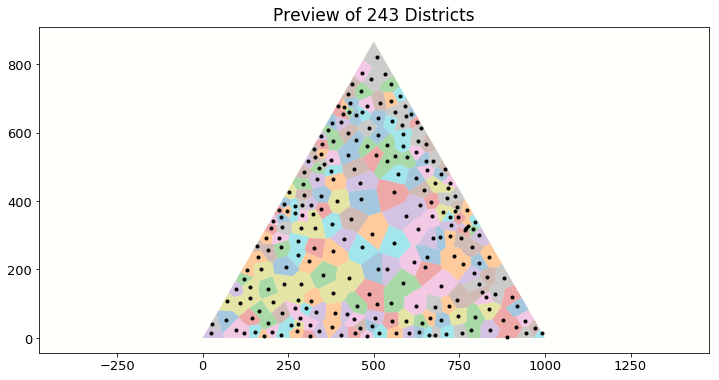

In [147]:
centroids = get_centroids(num_parties=2, w1=1, w2=0)
#print(centroids)
districts = get_districts(centroids) 
append_districts(newFileName, districts)

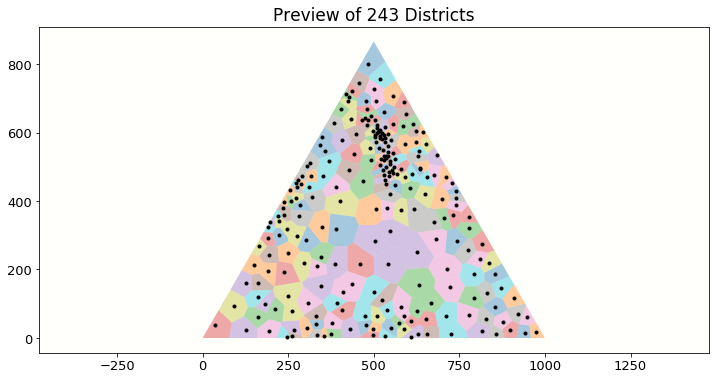

In [144]:
# centroids = generate_random_centroids(num_districts=243)
k_means_centroids_243, distortion = kmeans(Population_coords, 243) 

districts = get_districts(k_means_centroids_243) 
append_districts("voronoi_districts_243", districts)